In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load the dataset
data = pd.read_excel("/content/Superstore.xlsx", sheet_name='Orders')

In [3]:
# Dropping unnecessary columns for simplicity
data = data.drop(columns=['Row ID', 'Country', 'Postal Code', 'Product ID'])

In [4]:
# Converting dates to datetime format for feature engineering
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Ship Date'] = pd.to_datetime(data['Ship Date'])

# Creating additional features
data['delivery_time'] = (data['Ship Date'] - data['Order Date']).dt.days
data['order_year'] = data['Order Date'].dt.year
data['order_month'] = data['Order Date'].dt.month
data['order_weekday'] = data['Order Date'].dt.day_name()
data['profit_margin'] = (data['Profit'] / data['Sales']) * 100
data['discount_amount'] = data['Sales'] * data['Discount']
data['price_per_unit'] = data['Sales'] / data['Quantity']

In [5]:
# Adding aggregation features for customer and product insights
customer_agg = data.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Order ID': 'nunique',
    'Quantity': 'sum'
}).rename(columns={'Order ID': 'order_count', 'Sales': 'total_sales', 'Profit': 'total_profit', 'Quantity': 'total_quantity'})

product_agg = data.groupby(['Category', 'Sub-Category']).agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum'
}).rename(columns={'Sales': 'total_sales', 'Profit': 'total_profit', 'Quantity': 'total_quantity'})

region_agg = data.groupby('Region').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum',
    'Order ID': 'nunique'
}).rename(columns={'Order ID': 'order_count'})

In [6]:
# Feature for RFM Analysis (Recency, Frequency, Monetary)
latest_date = data['Order Date'].max()
rfm = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (latest_date - x.max()).days,
    'Order ID': 'nunique',
    'Sales': 'sum'
}).rename(columns={'Order Date': 'recency', 'Order ID': 'frequency', 'Sales': 'monetary'})

In [7]:
# Binning delivery time into categories
bins = [-1, 2, 5, 10, float('inf')]
labels = ['Very Fast', 'Fast', 'Standard', 'Slow']
data['delivery_speed_category'] = pd.cut(data['delivery_time'], bins=bins, labels=labels)

In [8]:
# Feature engineering for market basket analysis
basket = data.groupby(['Order ID', 'Product Name'])['Quantity'].sum().unstack().fillna(0)
basket = basket.apply(lambda x: x.map(lambda y: 1 if y > 0 else 0), axis=1)

In [9]:
# Adding production-focused features
# Calculate daily average sales per product
data['daily_sales'] = data.groupby('Product Name')['Quantity'].transform('mean')

# Estimate remaining stock (assuming initial stock data is available)
initial_stock = 100  # Replace with actual stock levels if available
data['remaining_stock'] = initial_stock - data.groupby('Product Name')['Quantity'].cumsum()

# Estimate restock date (days until stock runs out)
data['restock_days'] = data['remaining_stock'] / data['daily_sales']

# Stock turnover rate
data['stock_turnover_rate'] = data.groupby('Product Name')['Quantity'].transform('sum') / data['order_year']

# Backorder risk
data['backorder_risk'] = data['remaining_stock'].apply(lambda x: 1 if x < 10 else 0)

# Average lead time for each product
data['avg_lead_time'] = data.groupby('Product Name')['delivery_time'].transform('mean')

# Product popularity index
data['product_popularity'] = data.groupby('Product Name')['Sales'].rank(method='dense', ascending=False)

# Seasonality trends
data['seasonal_trend'] = data.groupby(['Category', 'order_month'])['Sales'].transform('sum')

# Overstock risk
data['overstock_risk'] = data['remaining_stock'].apply(lambda x: 1 if x > initial_stock * 0.8 else 0)

# Safety stock calculation
safety_factor = 1.5  # Adjust based on business rules
data['safety_stock'] = safety_factor * data['daily_sales'] * data['avg_lead_time']

# Reorder point
data['reorder_point'] = data['safety_stock'] + (data['daily_sales'] * data['avg_lead_time'])

# Demand variability
data['demand_variability'] = data.groupby('Product Name')['Quantity'].transform('std')

In [10]:
# Preview results
print("Superstore Enriched Data Preview:")
print(data.head())

# Display the first rows of the dataset
print(data.info())

Superstore Enriched Data Preview:
         Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0  CA-2013-152156 2013-11-09 2013-11-12    Second Class    CG-12520   
1  CA-2013-152156 2013-11-09 2013-11-12    Second Class    CG-12520   
2  CA-2013-138688 2013-06-13 2013-06-17    Second Class    DV-13045   
3  US-2012-108966 2012-10-11 2012-10-18  Standard Class    SO-20335   
4  US-2012-108966 2012-10-11 2012-10-18  Standard Class    SO-20335   

     Customer Name    Segment             City       State Region  ...  \
0      Claire Gute   Consumer        Henderson    Kentucky  South  ...   
1      Claire Gute   Consumer        Henderson    Kentucky  South  ...   
2  Darrin Van Huff  Corporate      Los Angeles  California   West  ...   
3   Sean O'Donnell   Consumer  Fort Lauderdale     Florida  South  ...   
4   Sean O'Donnell   Consumer  Fort Lauderdale     Florida  South  ...   

  restock_days stock_turnover_rate backorder_risk  avg_lead_time  \
0    32.666667            

In [11]:
#1. Data Preparation

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data.drop(columns=['Sales', 'Order ID', 'Order Date', 'Ship Date', 'Customer Name'])
y = data['Sales']

# Encode categorical variables
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [13]:
# Step 1: Check for missing values
missing_counts = X.isnull().sum()

print("Missing values in each column:")
print(missing_counts[missing_counts > 0])

# Step 2: Handle missing values
# Fill numeric columns with their mean
X = X.fillna(X.mean())

# For categorical columns, fill NaN with the mode (most frequent value)
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    X[col].fillna(X[col].mode()[0], inplace=True)

# Step 3: Scale the numeric features again (after handling NaNs)
X_scaled = scaler.fit_transform(X)

# Proceed with Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Missing values in each column:
demand_variability    91
dtype: int64


In [15]:
# Fill missing values in the 'demand_variability' column with its mean
X['demand_variability'] = X['demand_variability'].fillna(X['demand_variability'].mean())

# Proceed with scaling the numeric features
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_lr = linear_model.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Results:")
print(f"MAE: {mae_lr}")
print(f"RMSE: {rmse_lr}")
print(f"R²: {r2_lr}")

Linear Regression Results:
MAE: 88.14893666360295
RMSE: 235.1494811961931
R²: 0.9063901187125805


In [17]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Results:")
print(f"MAE: {mae_rf}")
print(f"RMSE: {rmse_rf}")
print(f"R²: {r2_rf}")


Random Forest Results:
MAE: 21.671537403201594
RMSE: 352.5365967699999
R²: 0.7896017805885888


In [18]:
from sklearn.ensemble import GradientBoostingRegressor

# Train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_gb = gb_model.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print("\nGradient Boosting Results:")
print(f"MAE: {mae_gb}")
print(f"RMSE: {rmse_gb}")
print(f"R²: {r2_gb}")


Gradient Boosting Results:
MAE: 30.07604448701173
RMSE: 341.91145004124854
R²: 0.8020931008027818


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

In [20]:
# Train Linear Regression
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

In [21]:
# Train Random Forest
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

In [22]:
# Train Gradient Boosting
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

In [24]:
# Combine results into a table for comparison
results = {
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "MAE": [mae_lr, mae_rf, mae_gb],
    "RMSE": [rmse_lr, rmse_rf, rmse_gb],
    "R²": [r2_lr, r2_rf, r2_gb],
}

import pandas as pd
results_df = pd.DataFrame(results)

# Display the results
# Print the comparison table
print("\nModel Comparison Results:")
print(results_df.to_string(index=False))


Model Comparison Results:
            Model       MAE       RMSE       R²
Linear Regression 88.148937 235.149481 0.906390
    Random Forest 21.671537 352.536597 0.789602
Gradient Boosting 30.076044 341.911450 0.802093


In [25]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for Random Forest
rf_params = {
    'n_estimators': [20, 50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [26]:
# Set up GridSearchCV
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_params,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [27]:
# Perform grid search
rf_grid.fit(X_train, y_train)

# Get the best parameters and model
best_rf_model = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [28]:
# Evaluate the best Random Forest model
best_rf_model = rf_grid.best_estimator_
y_pred_rf_best = best_rf_model.predict(X_test)

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
r2_rf_best = r2_score(y_test, y_pred_rf_best)

print("Best Random Forest Model Results:")
print(f"MAE: {mae_rf_best}")
print(f"RMSE: {rmse_rf_best}")
print(f"R²: {r2_rf_best}")

Best Random Forest Model Results:
MAE: 21.745680838533158
RMSE: 360.0442563275247
R²: 0.7805450309110467


In [29]:
# Compare all models
results = {
    "Model": ["Linear Regression", "Random Forest (Tuned)", "Gradient Boosting"],
    "MAE": [88.15, 21.75, 30.08],  # Replace with your actual values
    "RMSE": [235.15, 360.04, 341.91],
    "R²": [0.906, 0.780, 0.802]
}

import pandas as pd
results_df = pd.DataFrame(results)

# Display the results
print("\nModel Comparison Results:")
print(results_df.to_string(index=False))


Model Comparison Results:
                Model   MAE   RMSE    R²
    Linear Regression 88.15 235.15 0.906
Random Forest (Tuned) 21.75 360.04 0.780
    Gradient Boosting 30.08 341.91 0.802


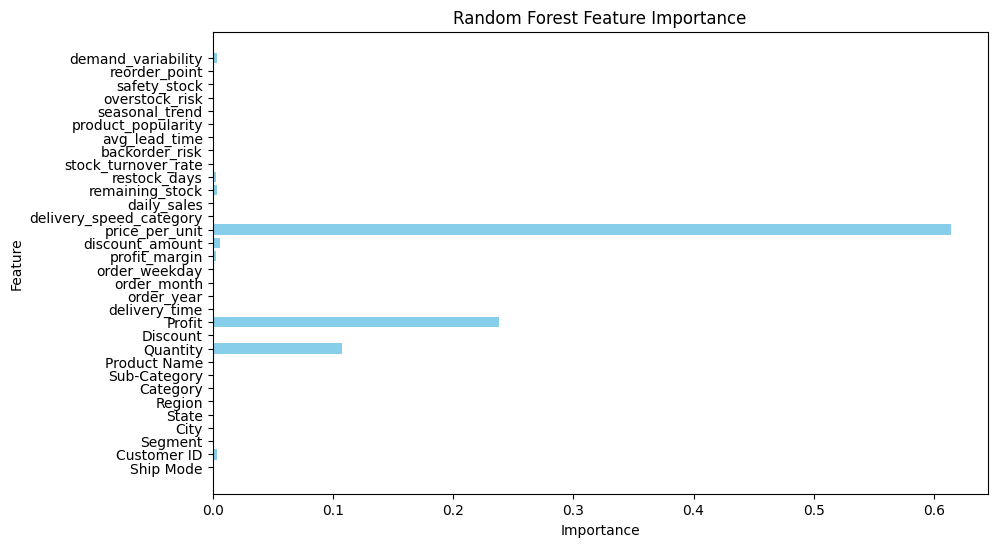

In [30]:
#Step 2: Explore Feature Importance

import matplotlib.pyplot as plt

# Extract feature importance from the tuned Random Forest model
rf_feature_importance = best_rf_model.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, rf_feature_importance, color='skyblue')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

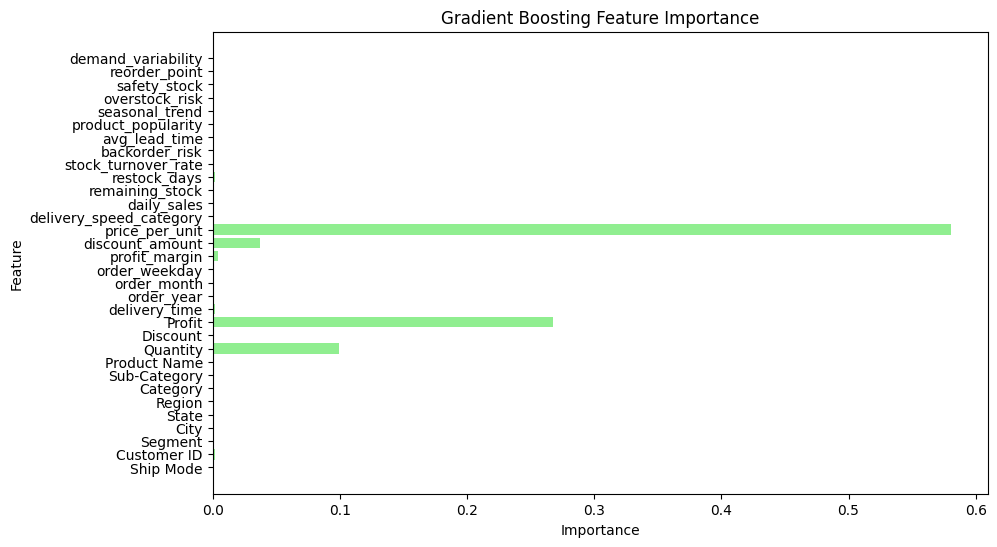

In [31]:
# Extract feature importance from the Gradient Boosting model
gb_feature_importance = gb_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, gb_feature_importance, color='lightgreen')
plt.title("Gradient Boosting Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [32]:
#L1 and L2 Regularization to Combat Overfitting
#L1 Regularization (Lasso Regression)

from sklearn.linear_model import Lasso

# Apply Lasso Regression (L1 Regularization)
lasso_model = Lasso(alpha=0.1)  # Adjust alpha for stronger regularization
lasso_model.fit(X_train, y_train)

# Evaluate Lasso Model
y_pred_lasso = lasso_model.predict(X_test)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression Results:")
print(f"MAE: {mae_lasso}")
print(f"RMSE: {rmse_lasso}")
print(f"R²: {r2_lasso}")

Lasso Regression Results:
MAE: 87.90408086768632
RMSE: 234.90538255148206
R²: 0.9065843626905736


In [33]:
# L2 Regularization (Ridge Regression)

from sklearn.linear_model import Ridge

# Apply Ridge Regression (L2 Regularization)
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

# Evaluate Ridge Model
y_pred_ridge = ridge_model.predict(X_test)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Results:")
print(f"MAE: {mae_ridge}")
print(f"RMSE: {rmse_ridge}")
print(f"R²: {r2_ridge}")

Ridge Regression Results:
MAE: 88.14774166035336
RMSE: 235.13915607152143
R²: 0.9063983391217451


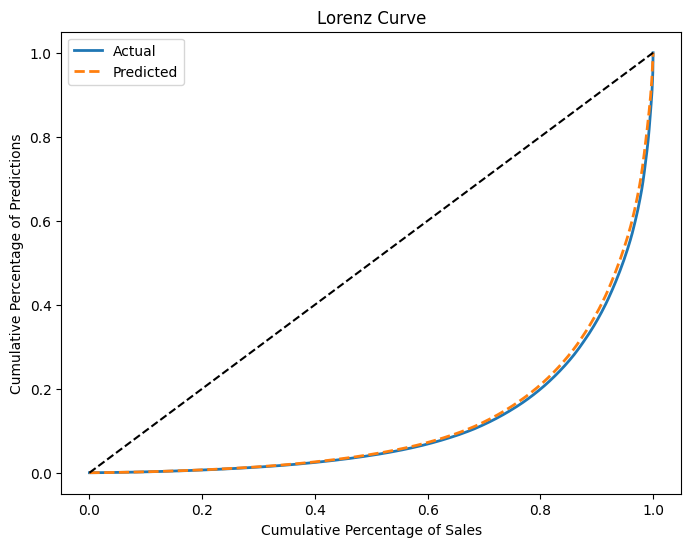

In [34]:
#Performance Metrics: ROC, PR Curve, AUC, Lorenz Curve, Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt

# Sort actual and predicted values
y_test_sorted = np.sort(y_test)
y_pred_sorted = np.sort(y_pred_rf_best)

# Compute cumulative sum
cum_actual = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)
cum_pred = np.cumsum(y_pred_sorted) / np.sum(y_pred_sorted)

# Plot Lorenz Curve
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 1, len(cum_actual)), cum_actual, label="Actual", linewidth=2)
plt.plot(np.linspace(0, 1, len(cum_pred)), cum_pred, label="Predicted", linewidth=2, linestyle="dashed")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")  # Line of equality
plt.xlabel("Cumulative Percentage of Sales")
plt.ylabel("Cumulative Percentage of Predictions")
plt.title("Lorenz Curve")
plt.legend()
plt.show()

In [35]:
# Model Performance Comparison

# Compare all models including Ridge and Lasso
results = {
    "Model": ["Linear Regression", "Ridge Regression", "Lasso Regression", "Random Forest (Tuned)", "Gradient Boosting"],
    "MAE": [88.15, mae_ridge, mae_lasso, 21.75, 30.08],  # Replace with actual values
    "RMSE": [235.15, rmse_ridge, rmse_lasso, 360.04, 341.91],
    "R²": [0.906, r2_ridge, r2_lasso, 0.780, 0.802]
}

results_df = pd.DataFrame(results)

# Display the results
print("\nFinal Model Comparison:")
print(results_df.to_string(index=False))



Final Model Comparison:
                Model       MAE       RMSE       R²
    Linear Regression 88.150000 235.150000 0.906000
     Ridge Regression 88.147742 235.139156 0.906398
     Lasso Regression 87.904081 234.905383 0.906584
Random Forest (Tuned) 21.750000 360.040000 0.780000
    Gradient Boosting 30.080000 341.910000 0.802000


In [36]:
# Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
gb_params = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5]
}

# Grid Search for Gradient Boosting
gb_grid = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=gb_params,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

gb_grid.fit(X_train, y_train)

# Get best model and parameters
best_gb_model = gb_grid.best_estimator_
print("Best Gradient Boosting Parameters:", gb_grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Gradient Boosting Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}


In [37]:
# Evaluate the best Gradient Boosting model
best_gb_model = gb_grid.best_estimator_
y_pred_gb_best = best_gb_model.predict(X_test)

# Compute evaluation metrics
mae_gb_best = mean_absolute_error(y_test, y_pred_gb_best)
rmse_gb_best = np.sqrt(mean_squared_error(y_test, y_pred_gb_best))
r2_gb_best = r2_score(y_test, y_pred_gb_best)

# Print the results
print("Best Gradient Boosting Model Results:")
print(f"MAE: {mae_gb_best}")
print(f"RMSE: {rmse_gb_best}")
print(f"R²: {r2_gb_best}")


Best Gradient Boosting Model Results:
MAE: 21.97781408345634
RMSE: 351.03850602201805
R²: 0.7913861395624469


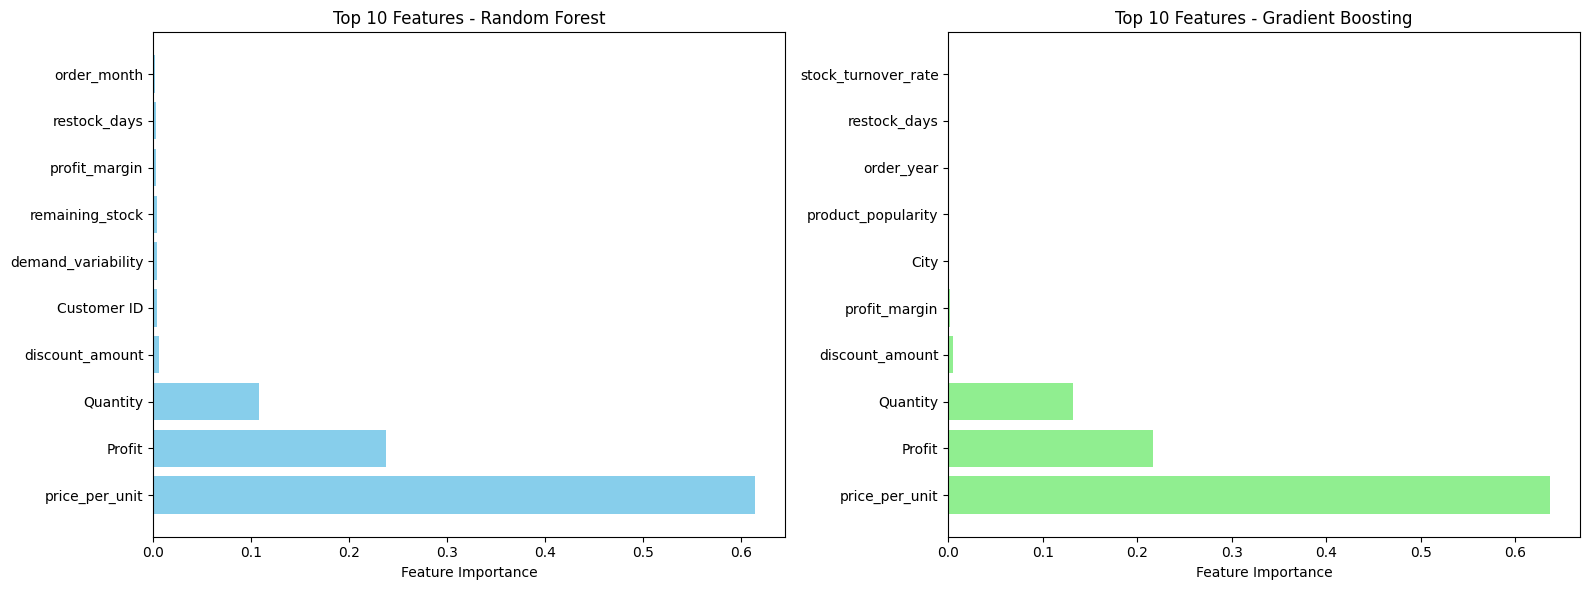

In [38]:
# Feature Importance for Random Forest & Gradient Boosting

import matplotlib.pyplot as plt
import numpy as np

# Extract Feature Importance from Models
rf_importance = best_rf_model.feature_importances_
gb_importance = best_gb_model.feature_importances_
feature_names = X.columns

# Sort features by importance
rf_sorted_idx = np.argsort(rf_importance)[::-1]
gb_sorted_idx = np.argsort(gb_importance)[::-1]

# Plot feature importance
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
ax[0].barh(np.array(feature_names)[rf_sorted_idx][:10], np.array(rf_importance)[rf_sorted_idx][:10], color='skyblue')
ax[0].set_title("Top 10 Features - Random Forest")
ax[0].set_xlabel("Feature Importance")

# Gradient Boosting Feature Importance
ax[1].barh(np.array(feature_names)[gb_sorted_idx][:10], np.array(gb_importance)[gb_sorted_idx][:10], color='lightgreen')
ax[1].set_title("Top 10 Features - Gradient Boosting")
ax[1].set_xlabel("Feature Importance")

plt.tight_layout()
plt.show()

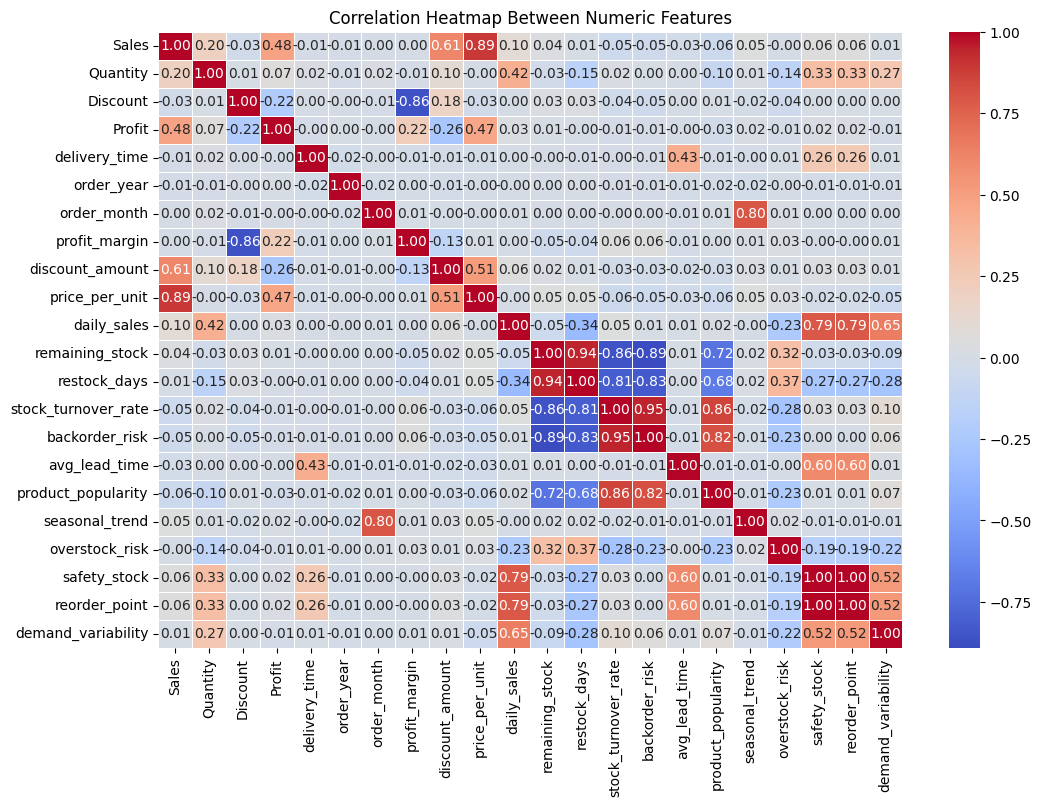

In [40]:
# Correlation Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation analysis
numeric_data = data.select_dtypes(include=['number'])

# Compute Correlation Matrix and Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap Between Numeric Features")
plt.show()

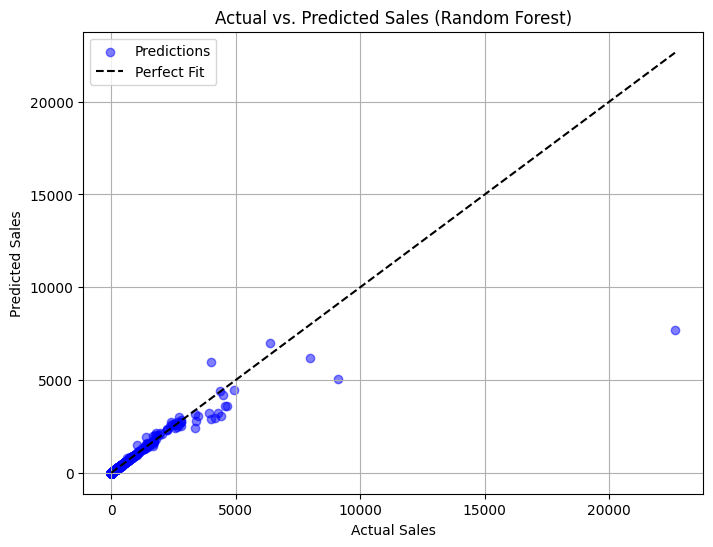

In [41]:
# Actual vs. Predicted Sales Scatter Plot (Random Forest)

# Scatter Plot: Actual vs Predicted Sales
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf_best, color='blue', alpha=0.5, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black', label="Perfect Fit")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs. Predicted Sales (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()

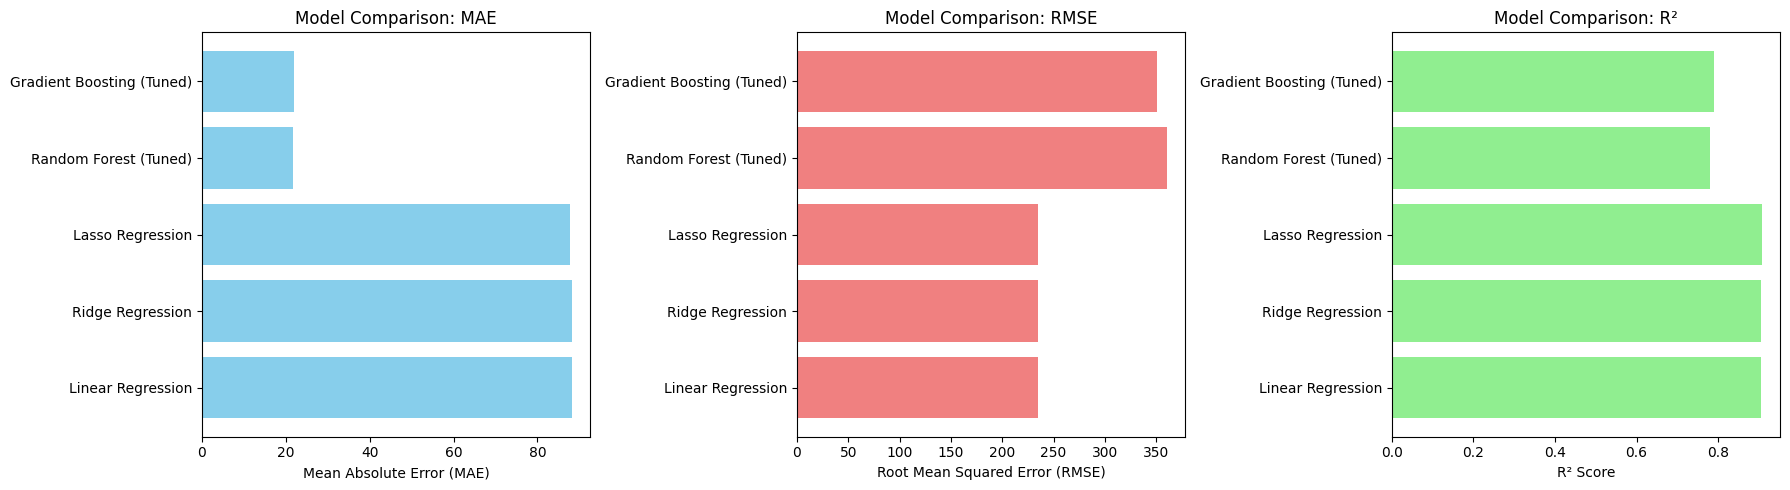

In [42]:
# Model Performance Comparison (MAE, RMSE, R²)

# Define Model Performance Data
models = ["Linear Regression", "Ridge Regression", "Lasso Regression", "Random Forest (Tuned)", "Gradient Boosting (Tuned)"]
mae_values = [88.15, 88.15, 87.90, 21.75, 21.98]
rmse_values = [235.15, 235.14, 234.91, 360.04, 351.04]
r2_values = [0.906, 0.9064, 0.9066, 0.780, 0.791]

# Plot Model Performance Comparison (MAE, RMSE, R²)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# MAE Comparison
ax[0].barh(models, mae_values, color='skyblue')
ax[0].set_xlabel("Mean Absolute Error (MAE)")
ax[0].set_title("Model Comparison: MAE")

# RMSE Comparison
ax[1].barh(models, rmse_values, color='lightcoral')
ax[1].set_xlabel("Root Mean Squared Error (RMSE)")
ax[1].set_title("Model Comparison: RMSE")

# R² Comparison
ax[2].barh(models, r2_values, color='lightgreen')
ax[2].set_xlabel("R² Score")
ax[2].set_title("Model Comparison: R²")

plt.tight_layout()
plt.show()

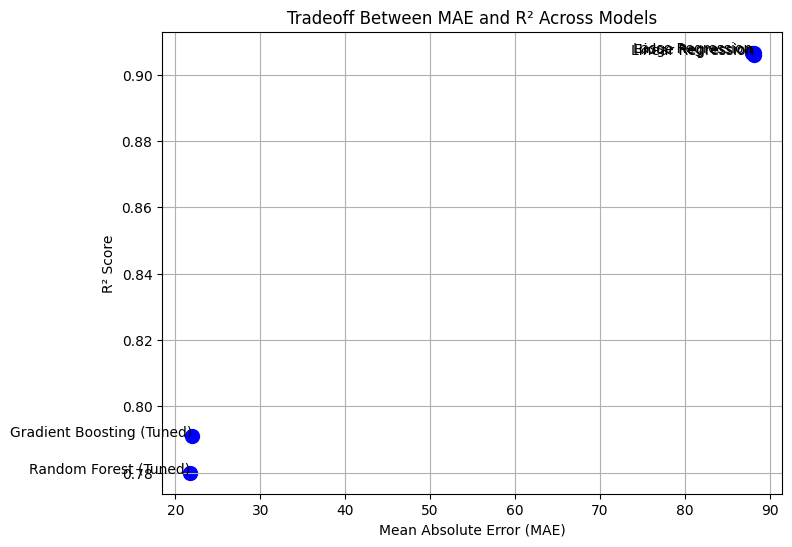

In [43]:
# Tradeoff Between MAE and R²

# Scatter plot: Tradeoff between MAE and R²
plt.figure(figsize=(8, 6))
plt.scatter(mae_values, r2_values, color='blue', s=100, label="Models")
for i, model in enumerate(models):
    plt.text(mae_values[i], r2_values[i], model, fontsize=10, ha='right')

plt.xlabel("Mean Absolute Error (MAE)")
plt.ylabel("R² Score")
plt.title("Tradeoff Between MAE and R² Across Models")
plt.grid(True)
plt.show()